<a href="https://colab.research.google.com/github/camulro/Aprendizaje-II/blob/sesi%C3%B3n2/cnn_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN con PyTorch - Ejemplo CIFAR-10

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
print(torch.__version__)

1.10.0+cu111


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size=4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(len(trainset))
print(len(testset))

Files already downloaded and verified
Files already downloaded and verified
50000
10000


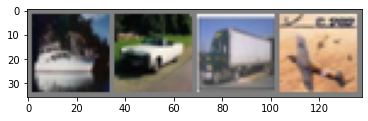

 ship   car truck plane


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(labels.size(0))))

In [ ]:
from torch.nn.modules.flatten import Flatten
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = x.view(-1, 16 * 5 * 5) #Alternativa a flatten
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [ ]:
# Sequential definition
import torch.nn as nn
import torch.nn.functional as F

net = nn.Sequential(
    # First conv-pool
    nn.Conv2d(3,6,5),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    # Second conv-pool
    nn.Conv2d(6,16,5),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    # Flatten
    nn.Flatten(1),
    # FC1
    nn.Linear(16 * 5 * 5, 120),
    nn.ReLU(),
    # FC2
    nn.Linear(120, 84),
    nn.ReLU(),
    # FC3
    nn.Linear(84, 10)
    )

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Training

# optional: measure time
import time

net.train()
train_loss=[]
epochs=10
start_time = time.time()

for epoch in range(epochs):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for data in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # loss is returned as an average over the batch_size: undo average
        running_loss += loss.item() * inputs.size(0)

    loss = running_loss / len(trainloader) # average over number of batches
    train_loss.append(loss)
    print('epoch [%d/%d] loss: %.3f' %
                (epoch + 1, epochs, loss))

print('Finished Training')
print("Elapsed time: %s seconds" % (time.time() - start_time))

epoch [1/10] loss: 6.809
epoch [2/10] loss: 5.385
epoch [3/10] loss: 4.817
epoch [4/10] loss: 4.420
epoch [5/10] loss: 4.144
epoch [6/10] loss: 3.926
epoch [7/10] loss: 3.739
epoch [8/10] loss: 3.559
epoch [9/10] loss: 3.450
epoch [10/10] loss: 3.324
Finished Training
Elapsed time: 333.1503767967224 seconds


(Text(0, 0.5, 'Train loss'), Text(0.5, 0, 'epoch'))

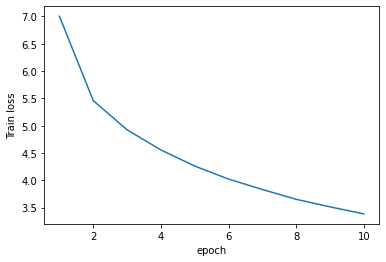

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1,epochs+1), train_loss)
plt.ylabel('Train loss'), plt.xlabel('epoch')

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

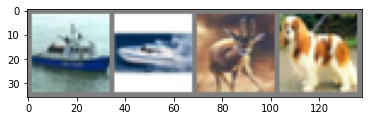

GroundTruth:   ship  ship  deer   dog


In [ ]:
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(labels.size(0))))

In [ ]:
images, labels = images.to(device), labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(predicted.size(0))))

Predicted:   ship  ship  deer  deer


In [ ]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 65 %
Accuracy of   car : 77 %
Accuracy of  bird : 49 %
Accuracy of   cat : 28 %
Accuracy of  deer : 61 %
Accuracy of   dog : 51 %
Accuracy of  frog : 75 %
Accuracy of horse : 69 %
Accuracy of  ship : 81 %
Accuracy of truck : 68 %
